2018-08-24 13:55:01,402 Appending to /home/albert/git/IonoTomo/src/ionotomo/data/NsolutionsDDE_2.5Jy_tecandphasePF_correctedlosoto_fulltime_dec27.h5.
2018-08-24 13:55:01,405 Closing table.
2018-08-24 13:55:01,407 Reading from /home/albert/git/IonoTomo/src/ionotomo/data/NsolutionsDDE_2.5Jy_tecandphasePF_correctedlosoto_fulltime_dec27.h5.
2018-08-24 13:55:01,409 Creating /net/lofar1/data1/albert/git/bayes_tec/notebooks/devel/ndppp_solutions.hdf5.
2018-08-24 13:55:01,411 Creating a new solution-set: sol000.
2018-08-24 13:55:01,413 --Creating new antenna table.
2018-08-24 13:55:01,416 --Creating new source table.
2018-08-24 13:55:01,418 Closing table.
2018-08-24 13:55:01,420 Appending to /net/lofar1/data1/albert/git/bayes_tec/notebooks/devel/ndppp_solutions.hdf5.


/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/atom.py:393: FlavorWarning: support for unicode type is very limited, and only works for strings that can be cast as ascii
  "and only works for strings that can be cast as ascii", FlavorWarning)


2018-08-24 13:55:10,577 Creating a new solution-table: phase000.
2018-08-24 13:55:14,978 Closing table.
2018-08-24 13:55:14,982 Closing table.
2018-08-24 13:55:14,984 Appending to /net/lofar1/data1/albert/git/bayes_tec/notebooks/devel/ndppp_solutions.hdf5.
2018-08-24 13:55:14,987 Closing table.
2018-08-24 13:55:14,988 Appending to /net/lofar1/data1/albert/git/bayes_tec/notebooks/devel/ndppp_solutions.hdf5.


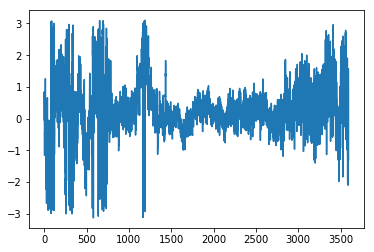

2018-08-24 13:55:15,944 Closing table.


In [8]:
"""This loads the data from Reinout's reduction into a DataPack"""
from bayes_tec.datapack import DataPack
import h5py
import numpy as np
import os
import sys
from bayes_tec.logging import logging

if sys.hexversion >= 0x3000000:
    def str_(s):
        return str(s,'utf-8')
else:
    def str_(s):
        return str(s)

#TECU = 1e16
tec_conversion = -8.4480e9# rad Hz/tecu

def _wrap(x):
    return np.angle(np.exp(1j*x))

def import_data(dd_file, datapack, clobber=False,chan_per_block = 20):
    """Create a datapack from the direction dependent NDPPP solutions.
    dd_file : str
        path to dd solutions made by NDPPP
    datapack_file : str
        path to store resulting DataPack

    Note: assumes dtypes in hdf5 files are float
    """
    if os.path.exists(datapack):
        if clobber:
            os.unlink(datapack)
        else:
            raise ValueError("{} already exists and non clobber".format(datapack))
        
    with DataPack(dd_file,readonly=True) as f_dd:
        freqs = np.array([120.,130.,140.,150.,160.])*1e6
        with DataPack(datapack) as out:
            patch_names, directions = f_dd.sources
            antenna_labels, antennas = f_dd.antennas
            out.add_antennas()#default is lofar
            out.add_sources(directions, patch_names=patch_names)
            
            tec,axes = f_dd.tec#(npol), nt, na, nd,1
            
            if 'pol' in axes.keys():#(1,3595,62,1,42,1)
                tec = tec[...,0].transpose((0,3,2,1))#npol,nd,na,nt
                phase = tec_conversion*tec[:,:,:,None,:]/freqs[None,None,None,:,None]
            else:
                tec = tec[...,0].transpose((2,1,0))#nd,na,nt
                phase = tec_conversion*tec[None,:,:,None,:]/freqs[None,None,None,:,None]
                axes['pol'] = ['XX']
                
            out.add_freq_dep_tab('phase', axes['time'], freqs, pols=axes['pol'], ants = axes['ant'], 
                                 dirs = axes['dir'], vals=_wrap(phase))
    with DataPack(datapack) as out:
        phase,_ = out.phase
        import pylab as plt
        plt.plot(phase[0,0,51,2,:])
        plt.show()
        

if __name__=='__main__':
    import_data("/home/albert/git/IonoTomo/src/ionotomo/data/NsolutionsDDE_2.5Jy_tecandphasePF_correctedlosoto_fulltime_dec27.h5",
            "ndppp_solutions.hdf5",
            clobber=True)
#    from ionotomo.plotting.plot_tools import plot_datapack, animate_datapack
#    datapack = DataPack(filename="rvw_datapack_full_phase_dec27_fullfreq.hdf5")
##    animate_datapack(datapack,"rvw_datapack_animation_std_dec27", num_threads=1,mode='perantenna',observable='std')
#    animate_datapack(datapack,"rvw_datapack_animation_phase_dec27_fullfreq", num_threads=1,mode='perantenna',observable='phase',phase_wrap=False)
    


